In [1]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
from bokeh.models import Range1d

Loading BokehJS ...

# VAE - MLP

In [2]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
from tqdm import tqdm, tqdm_notebook

gpu_ctx = mx.gpu(0)
cpu_ctx = mx.cpu(0)
mx.random.seed(1)

/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


# Parameters

In [3]:
FILTERS = 64
LATENT_DIM = 2
HIDDEN_DIM = 400
INTPUT_DIM = 28 * 28
OUTPUT_DIM = 28 * 28
BATCH_SIZE = 100
IMG_CHNS = 1

# Define functions

In [4]:
def vae_loss(x, x_gen, z_mean, log_z_var):
    x = nd.flatten(x)
    x_gen = nd.flatten(x_gen)
    #print('x shape = {}'.format(x.shape))
    #print('x_gen sahpe = {}'.format(x_gen.shape))
    # D_KL(q(z|X) || p(z))
    kl_loss = -0.5 * nd.sum(1 + log_z_var - nd.square(z_mean) - nd.exp(log_z_var), axis = 1)
    # E(log p(X|z))
    log_loss = - nd.sum(x* nd.log(x_gen + 1e-6), axis=1)
    return nd.sum(kl_loss + log_loss)

def sample_z(args):
    mean, log_var = args
    eps = nd.random_normal(shape = mean.shape, loc = 0., scale = 1., ctx = gpu_ctx)
    #print(eps[0:5].asnumpy())
    #print(log_var.shape)
    #print(mean.shape)
    #print(eps.shape)
    return mean + nd.exp(log_var / 2) * eps

class sample_layer(gluon.Block):
    def __init__(self, *args):
        super(sample_layer, self).__init__(*args)
        self.args = args

    def forward(self, x):
        return sample_z(self.args)

# Load Dataset
* transform 함수는 한개의 data에 대해 적용됨
* BATCH SIZE는 무시하고 dimension 변환


In [5]:
mnist = mx.test_utils.get_mnist()

def transform(data, label):
    #print(data.shape)
    res = nd.transpose(data, (2, 0, 1))
    res = res.astype(np.float32) / 255
    return res, label

# lambda data, label: (data.astype(np.float32)/255, label)
train_data = mx.gluon.data.DataLoader( \
                 mx.gluon.data.vision.MNIST( \
                     train = True, \
                     transform = transform), \
                     BATCH_SIZE, shuffle = True)

test_data = mx.gluon.data.DataLoader( \
                 mx.gluon.data.vision.MNIST( \
                     train = False, transform = transform), \
                     BATCH_SIZE, shuffle=False)

# Define Encoder

In [6]:
class Encoder(gluon.Block):
    def __init__(self, filters, latent_dim, **kwarg):
        super(Encoder, self).__init__(**kwarg)
        with self.name_scope():
            # in_channel: 나중에 판단
            # layout: NCHW
            self.dense_1 = gluon.nn.Dense(units = HIDDEN_DIM, activation = 'relu')
            self.dense_2 = gluon.nn.Dense(units = HIDDEN_DIM, activation = 'relu')
            self.dense_3 = gluon.nn.Dense(units = 2 * latent_dim, activation = None)
            
    def forward(self, x):
        #print("input shape : {}".format(x.shape))
        x = self.dense_1(x)
        #print("conv2D_1 shape : {}".format(x.shape))
        x = self.dense_2(x)
        #print("conv2D_1 shape : {}".format(x.shape))
        x = self.dense_3(x)
        return x

## check encoder dimensions

In [7]:
enc = Encoder(FILTERS, LATENT_DIM)
print(enc)
enc.collect_params().initialize(mx.init.Xavier(), ctx = gpu_ctx)
test_input = nd.random_normal(0,1,(1, 1, 28, 28), ctx = gpu_ctx)
enc(test_input).shape

Encoder(
  (dense_1): Dense(None -> 400, Activation(relu))
  (dense_2): Dense(None -> 400, Activation(relu))
  (dense_3): Dense(None -> 4, linear)
)


(1, 4)

# Define Decoder
* in_units는 설정하지 않음
* 여러 block을 사용할 것이므로, name_scope를 꼭 사용

In [8]:
class Decoder(gluon.Block):
    def __init__(self, hidden_dim, output_dim, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        with self.name_scope():
            self.dense_1 = gluon.nn.Dense(units = hidden_dim, activation = 'relu')
            self.dense_2 = gluon.nn.Dense(units = hidden_dim, activation = 'relu')
            # Output을 0과 1 사이로 맞추었으므로..
            self.dense_3 = gluon.nn.Dense(units = output_dim, activation = 'sigmoid')
    
    def forward(self, x):
        x = self.dense_1(x)
        #print('after dense1....%s'%str(x.shape))
        x = self.dense_2(x)
        #print('after dense2.... %s'%str(x.shape))
        x = self.dense_3(x)
        #print('after dense2.... %s'%str(x.shape))
        return x

## Check decoder dimensions
* 4-dim으로 reshape NCHW
* decoder의 input으로 (-1, HIDDEN_DIM)으로 변환해서 넣어주어야 함 (data.reshape(-1, HIDDEN_DIM) 이용)

In [9]:
dec = Decoder(HIDDEN_DIM, OUTPUT_DIM)
print(dec)
dec.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx = gpu_ctx)
# Simulate dimension
test_input = nd.random_normal(0,1,shape= LATENT_DIM, ctx = gpu_ctx)
test_input = test_input.reshape((-1, LATENT_DIM))
dec(test_input).shape

Decoder(
  (dense_1): Dense(None -> 400, Activation(relu))
  (dense_2): Dense(None -> 400, Activation(relu))
  (dense_3): Dense(None -> 784, Activation(sigmoid))
)


(1, 784)

In [10]:
# Batch size가 필요함
# name_scope를 사용해야 함
class VAE(gluon.Block):
    def __init__(self, filters, latent_dim, output_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        with self.name_scope():
            self.enc = Encoder(filters, latent_dim)
            self.dec = Decoder(filters, output_dim)
            self.latent_dim = latent_dim
            self.x_gen = None
            self.z_mean = None
            self.log_z_var = None
            self.x_gen = None
            
    def forward(self, x):
        h = self.enc(x)
        #print('x\'s shape after enc = {}'.format(x.shape))
        self.z_mean = h.slice(begin = (None, 0), end = (None, self.latent_dim))
        self.log_z_var = h.slice(begin = (None, self.latent_dim), end = (None, 2 * self.latent_dim))
        z = sample_z([self.z_mean, self.log_z_var])
        self.x_gen = self.dec(z)
        #print('x_gen dim = {}'.format(x_gen.shape))
        kl_loss = -0.5 *nd.sum(1 + self.log_z_var - nd.square(self.z_mean) - nd.exp(self.log_z_var), axis =1)
        logloss = - nd.sum(x * nd.log(self.x_gen + 1e-6) + (1 - x) * nd.log(1 - self.x_gen + 1e-6), axis = 1)

        return nd.sum(kl_loss + logloss)


In [11]:
vae = VAE(FILTERS, LATENT_DIM, OUTPUT_DIM)
print(vae)

VAE(
  (enc): Encoder(
    (dense_1): Dense(None -> 400, Activation(relu))
    (dense_2): Dense(None -> 400, Activation(relu))
    (dense_3): Dense(None -> 4, linear)
  )
  (dec): Decoder(
    (dense_1): Dense(None -> 64, Activation(relu))
    (dense_2): Dense(None -> 64, Activation(relu))
    (dense_3): Dense(None -> 784, Activation(sigmoid))
  )
)


## Check VAE dimensions

In [12]:
# Simulate dimension
test_input = nd.random_normal(0,1,shape= (1, 28 * 28), ctx = gpu_ctx)
vae.collect_params().initialize(mx.init.Xavier(), ctx = gpu_ctx)
vae(test_input)


[ 543.26104736]
<NDArray 1 @gpu(0)>

# Define Trainer

In [13]:
trainer = gluon.Trainer(vae.collect_params(), 'adam', {'learning_rate': .001})

# Training

In [15]:
EPOCHS = 50

los = []
for e in tqdm_notebook(range(EPOCHS), desc='epochs'):
    for i, (data, label) in enumerate(train_data):
        x = data.as_in_context(gpu_ctx).reshape((-1, 28 * 28))
        
    with autograd.record():
        loss = vae(x)
        loss.backward()
        trainer.step(data.shape[0])
        tqdm.write('epoch: {}, cur_loss = {}'.format(e, loss.asnumpy()))
        los.append(loss.asnumpy())

A Jupyter Widget

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



MXNetError: [12:17:43] src/imperative/imperative.cc:192: Check failed: AGInfo::IsNone(*(outputs[i])) Assigning to NDArrays that are already in a computational graph will cause undefined behavior when evaluating gradients. Please call backward first to clear the graph or do this out side of a record section. 

Stack trace returned 10 entries:
[bt] (0) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x28965c) [0x7f165fcad65c]
[bt] (1) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24bef3b) [0x7f1661ee2f3b]
[bt] (2) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x2402916) [0x7f1661e26916]
[bt] (3) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(MXImperativeInvokeEx+0x63) [0x7f1661e26bf3]
[bt] (4) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f16a28ceec0]
[bt] (5) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f16a28ce87d]
[bt] (6) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f16a2ae382e]
[bt] (7) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12265) [0x7f16a2ae4265]
[bt] (8) /home/kionkim/anaconda3/envs/kion_venv_mxnet/bin/python(_PyObject_FastCallDict+0x8b) [0x56470549d54b]
[bt] (9) /home/kionkim/anaconda3/envs/kion_venv_mxnet/bin/python(+0x19f00e) [0x56470553000e]


## Save model

In [17]:
# Path to save parameters
model_prefix = 'vae_gluon.params'
vae.save_params(model_prefix)

# Predict

## Load model

In [18]:
vae2 = VAE(FILTERS, LATENT_DIM, OUTPUT_DIM)
vae2.load_params(model_prefix, ctx=gpu_ctx)

In [19]:
p = figure()
p.circle(vae.z_mean[:, 0].asnumpy(), vae.z_mean[:, 1].asnumpy())
show(p)


## Get test image

In [20]:
NUM_TEST = 10

In [21]:
for i, (data) in enumerate(test_data):
    test_image = data[0][0:NUM_TEST, :, :, :]
    test_label = data[1]
    if i == 1:
        break

## Reconstruct image
  * vae2의 결과물은 [x_gen, z_mean, z_log_var]의 list형태

In [22]:
gen_img = []
lat_space = []
for i, im in enumerate(test_image):
    res = vae2(im.as_in_context(gpu_ctx).reshape((-1, 28 * 28)))
    res = vae2.x_gen
    gen_img.append(res.asnumpy())
    lat_space.append([vae2.z_mean.asnumpy(), vae2.log_z_var.asnumpy()])

x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)
x.shape = <class 'mxnet.ndarray.ndarray.NDArray'>, y.shape = (1, 784)


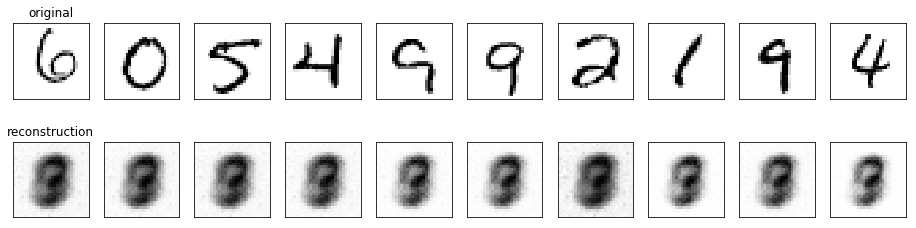

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = test_image.shape[0]
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))

for i, (x, y) in enumerate(zip(test_image, gen_img)):
    print('x.shape = {}, y.shape = {}'.format(type(x.reshape((28,28))), y.shape))
    # Numpy이어야 함. mxnet.ndarray는 안됨
    axarr[0,i].imshow(x.reshape((28,28)).asnumpy(), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])
    axarr[1,i].imshow(gen_img[i].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

test_input = nd.random_normal(loc = 0,scale = 2,shape= LATENT_DIM, ctx = gpu_ctx)
t_i = test_input.reshape((-1, LATENT_DIM))
test_gen = dec(t_i)
t_g = nd.transpose(test_gen, (0, 2, 3, 1))
im = nd.transpose(t_g,(1,0,2,3))
im = nd.reshape(im,(28, 28,1))
imtiles = nd.tile(im, (1,1,3))
plt.imshow(imtiles.asnumpy())
plt.show()

MXNetError: [00:48:28] src/operator/tensor/./matrix_op-inl.h:310: Check failed: shp.ndim() == param.axes.ndim() (2 vs. 4) 

Stack trace returned 10 entries:
[bt] (0) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x28965c) [0x7f58a2f7465c]
[bt] (1) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x226b868) [0x7f58a4f56868]
[bt] (2) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24d573f) [0x7f58a51c073f]
[bt] (3) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24c1be9) [0x7f58a51acbe9]
[bt] (4) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24026bb) [0x7f58a50ed6bb]
[bt] (5) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(MXImperativeInvokeEx+0x63) [0x7f58a50edbf3]
[bt] (6) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f58e5b8fec0]
[bt] (7) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f58e5b8f87d]
[bt] (8) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f58e5da482e]
[bt] (9) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12265) [0x7f58e5da5265]


In [28]:
test_gen


[[[[ 0.50028056  0.50006336  0.50001007  0.50009346  0.49996209  0.50000113
     0.49992168  0.49999869  0.50012594  0.50015461  0.49982446  0.49991751
     0.50012875  0.49998283  0.500054    0.50003207  0.49995345  0.50020087
     0.50006247  0.50009751  0.50001132  0.50002122  0.50020128  0.50011408
     0.50015682  0.50007886  0.50016648  0.49989346]
   [ 0.50011837  0.50011653  0.50027168  0.50032485  0.50028926  0.50001252
     0.50006485  0.49996322  0.50024915  0.50002694  0.50019926  0.50000727
     0.50022888  0.50010306  0.50001353  0.50021893  0.5002014   0.4999401
     0.50021875  0.49995762  0.50036168  0.50027966  0.49988237  0.50007564
     0.50023842  0.50001597  0.50022185  0.50012606]
   [ 0.50005227  0.49979421  0.50009608  0.49971488  0.50017655  0.50009847
     0.5001843   0.49974751  0.50009674  0.49989203  0.50011927  0.49963233
     0.50005466  0.50025785  0.49996638  0.49961466  0.49995768  0.49970406
     0.50039279  0.49965215  0.50003338  0.50002873  0.500

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def model_predict(net,data):
    output = dec(data.as_in_context(model_ctx))
    return nd.argmax(output, axis=1)

NUM_EXAMPLES = 10
# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              NUM_EXAMPLES, shuffle=True)

for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(gpu_ctx)
    data_t = nd.transpose(data, (0, 2, 3, 1))
    im1 = nd.transpose(data,(1, 0, 2, 3))
    im1 = nd.reshape(im1,(28, NUM_EXAMPLES * 28,1))
    imtiles1 = nd.tile(im1, (1,1,3))
    
    gen, _, _ = vae(data)
    gen_t = nd.transpose(gen, (0, 2, 3, 1))
    im2 = nd.transpose(gen_t,(1, 0, 2, 3))
    im2 = nd.reshape(im2,(28, NUM_EXAMPLES * 28, 1))
    imtiles2 = nd.tile(im2, (1,1,3))
    
    f, (plt1, plt2) = plt.subplots(2, 1)
    plt1.imshow(imtiles1.asnumpy())
    plt2.imshow(imtiles2.asnumpy())
    f.show()
    #pred=model_predict(net,data.reshape((-1,784)))
    #print('model predictions are:', pred)
    break